https://ui.neptune.ai/jakub-czakon/blog-hpo/e/BLOG-97/source-code?path=.&file=search_forest.py&utm_source=medium&utm_medium=crosspost&utm_campaign=blog-scikit-optimize&utm_content=explore-script

In [11]:
cd /content/drive/My Drive/University/FYP/Sentiment Analysis/Implementation/tutorial/skparam

/content/drive/My Drive/University/FYP/Sentiment Analysis/Implementation/tutorial/kaggle/skparam


# Utils

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split

NUM_BOOST_ROUND = 300
EARLY_STOPPING_ROUNDS = 30

def train_evaluate(X, y, params):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1234)

    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

    model = lgb.train(params, train_data,
                      num_boost_round=NUM_BOOST_ROUND,
                      early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                      valid_sets=[valid_data], 
                      valid_names=['valid'])
    
    score = model.best_score['valid']['auc']
    return score
        
    
def axes2fig(axes, figsize=(16,12)):
    fig = plt.figure(figsize=figsize)
    try:
        h, w = axes.shape
        for i in range(h):
            for j in range(w):
                fig._axstack.add(fig._make_key(axes[i, j]), axes[i, j])
    except AttributeError:
        fig._axstack.add(fig._make_key(axes), axes)
    return fig
    

# Neptune

In [0]:
!pip install neptune-client

In [15]:
import neptune

# The init() function called this way assumes that 
# NEPTUNE_API_TOKEN environment variable is defined.

neptune.init(project_qualified_name='lahiru/sandbox', api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiOTYyNDQ5NDUtYWNjMi00YzU5LWE1NDEtOTY2Y2NhY2UwZDU5In0=")
neptune.create_experiment(name='minimal_example')

# log some metrics

for i in range(100):
    neptune.log_metric('loss', 0.95**i)

neptune.log_metric('AUC', 0.96)

https://ui.neptune.ai/lahiru/sandbox/e/SAN-2


# Search_Forest

In [0]:
!pip install scikit-optimize

In [5]:
import matplotlib.pyplot as plt
import neptune
import pandas as pd
import skopt
import skopt.plots
from sklearn.externals import joblib

# from utils import train_evaluate, axes2fig

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [6]:
neptune.init(project_qualified_name='lahiru/skparam', api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiOTYyNDQ5NDUtYWNjMi00YzU5LWE1NDEtOTY2Y2NhY2UwZDU5In0=")

N_ROWS=10000
TRAIN_PATH = '/content/drive/My Drive/University/FYP/Sentiment Analysis/Implementation/tutorial/kaggle/train/train.csv'
STATIC_PARAMS = {'boosting': 'gbdt',
                'objective':'binary',
                'metric': 'auc',
                'num_threads': 12,
                }
HPO_PARAMS = {'n_calls':100,
              'n_random_starts':10,
              'base_estimator':'ET',
              'acq_func':'EI',
              'xi':0.02,
              'kappa':1.96,
              'n_points':10000,
             }

SPACE = [skopt.space.Real(0.01, 0.5, name='learning_rate', prior='log-uniform'),
         skopt.space.Integer(1, 30, name='max_depth'),
         skopt.space.Integer(2, 100, name='num_leaves'),
         skopt.space.Integer(10, 1000, name='min_data_in_leaf'),
         skopt.space.Real(0.1, 1.0, name='feature_fraction', prior='uniform'),
         skopt.space.Real(0.1, 1.0, name='subsample', prior='uniform'),
         ]

data = pd.read_csv(TRAIN_PATH, nrows=N_ROWS)
    
X = data.drop(['ID_code', 'target'], axis=1)
y = data['target']

In [0]:
@skopt.utils.use_named_args(SPACE)
def objective(**params):
    all_params = {**params, **STATIC_PARAMS}
    return -1.0 * train_evaluate(X, y, all_params)

experiment_params = {**STATIC_PARAMS, 
                     **HPO_PARAMS,
                     'n_rows': N_ROWS
                    }

def to_named_params(params):
    return([(dimension.name, param) for dimension, param in zip(SPACE, params)])

def monitor(res):
    neptune.send_metric('run_score', res.func_vals[-1])
    neptune.send_text('run_parameters', str(to_named_params(res.x_iters[-1])))

Streaming output truncated to the last 5000 lines.
[202]	valid's auc: 0.820482
[203]	valid's auc: 0.820565
[204]	valid's auc: 0.821095
[205]	valid's auc: 0.82067
[206]	valid's auc: 0.821008
[207]	valid's auc: 0.821118
[208]	valid's auc: 0.820482
[209]	valid's auc: 0.821093
[210]	valid's auc: 0.821115
[211]	valid's auc: 0.821121
[212]	valid's auc: 0.821426
[213]	valid's auc: 0.821151
[214]	valid's auc: 0.821153
[215]	valid's auc: 0.821231
[216]	valid's auc: 0.821644
[217]	valid's auc: 0.822483
[218]	valid's auc: 0.822085
[219]	valid's auc: 0.821759
[220]	valid's auc: 0.821611
[221]	valid's auc: 0.821857
[222]	valid's auc: 0.821817
[223]	valid's auc: 0.821739
[224]	valid's auc: 0.822112
[225]	valid's auc: 0.821982
[226]	valid's auc: 0.821964
[227]	valid's auc: 0.82211
[228]	valid's auc: 0.821764
[229]	valid's auc: 0.822317
[230]	valid's auc: 0.822132
[231]	valid's auc: 0.821977
[232]	valid's auc: 0.822152
[233]	valid's auc: 0.821802
[234]	valid's auc: 0.821879
[235]	valid's auc: 0.82215


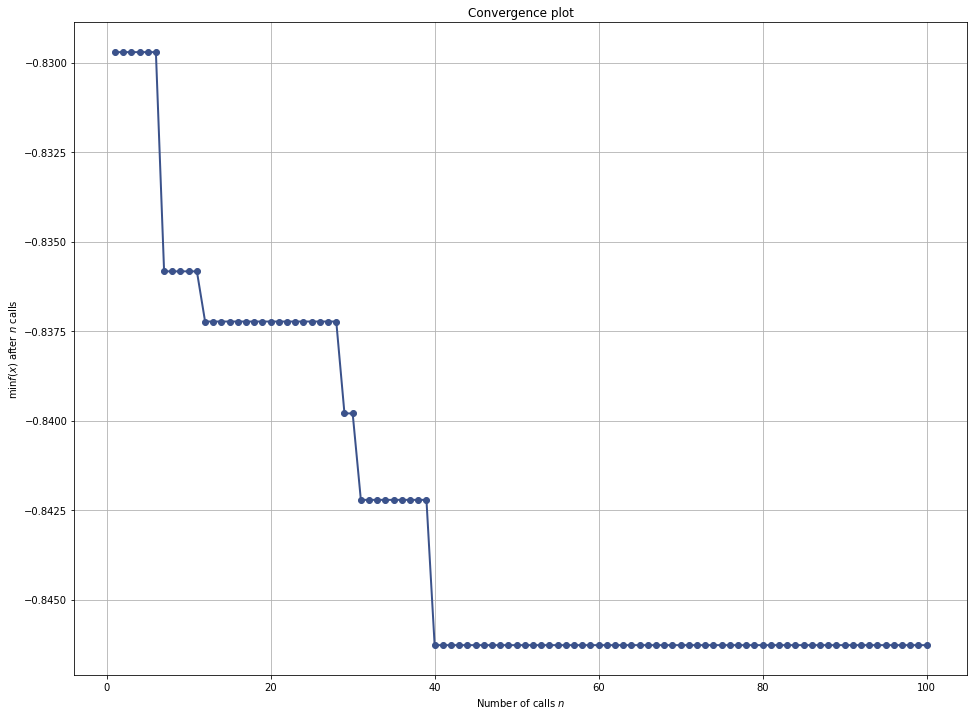

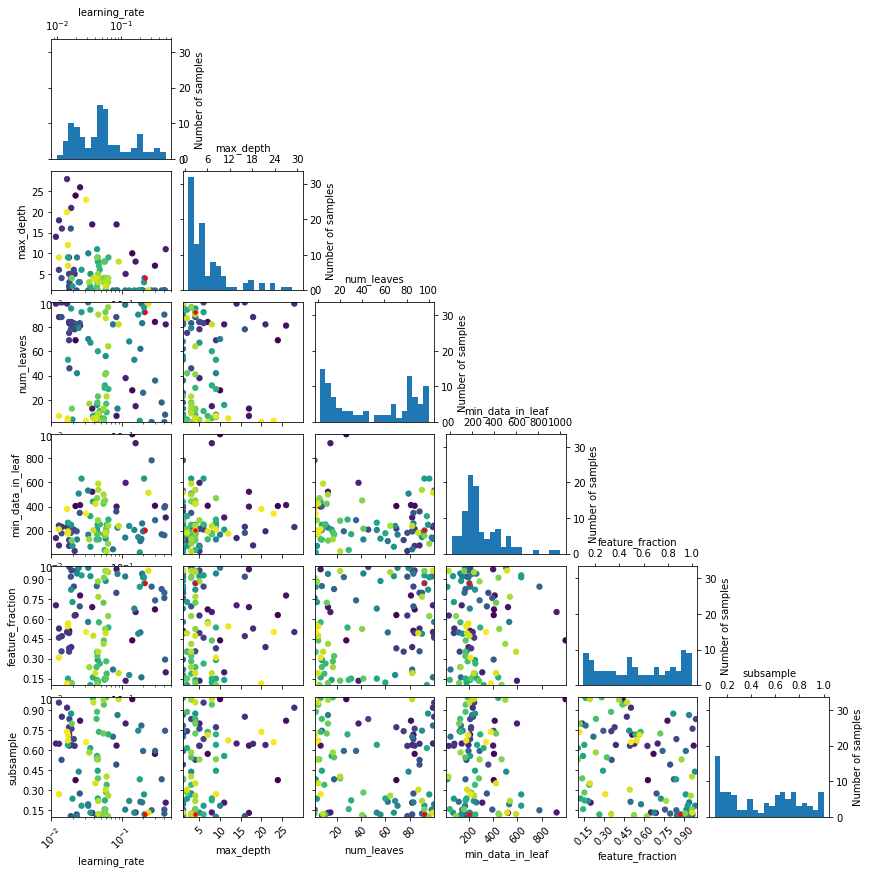

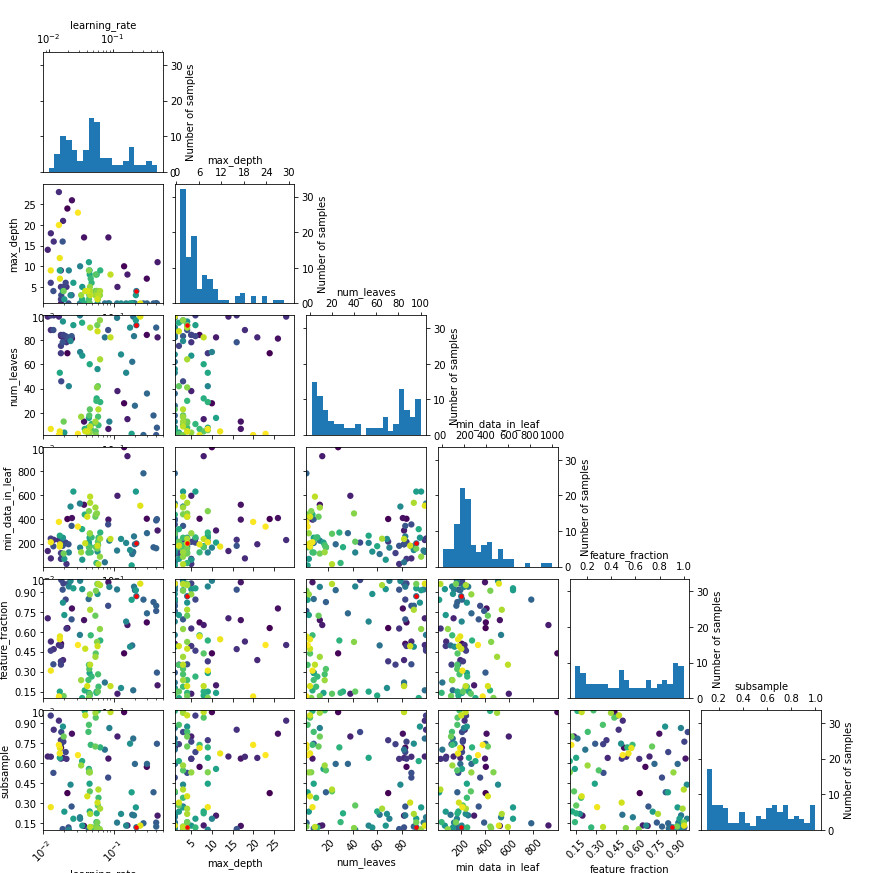

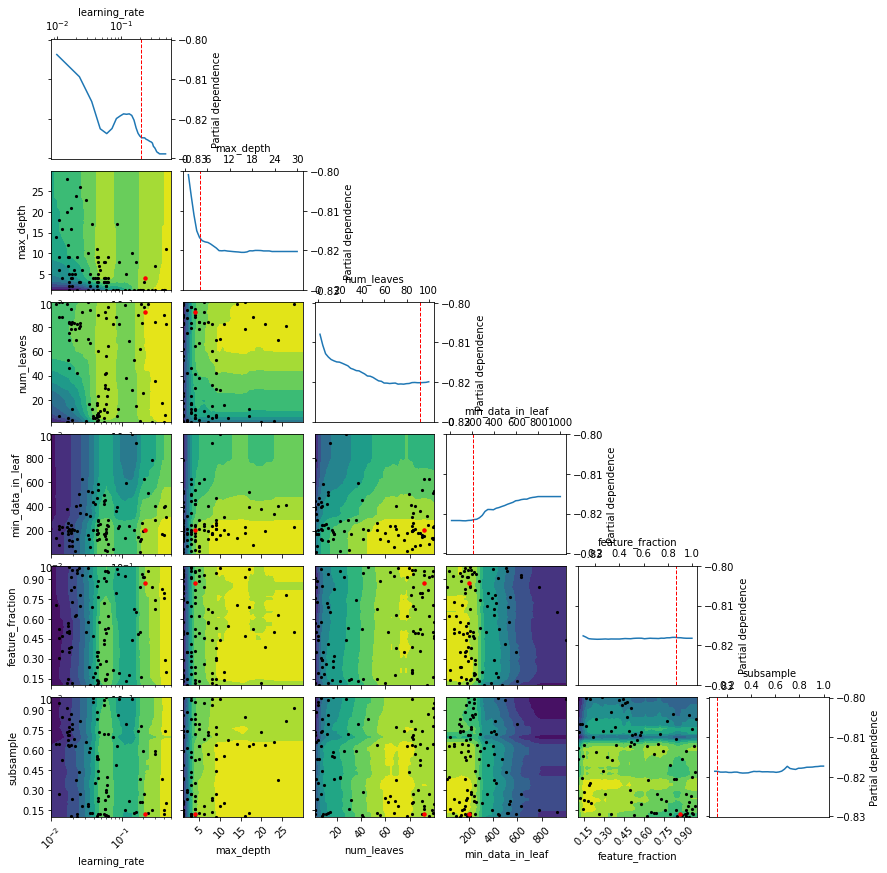

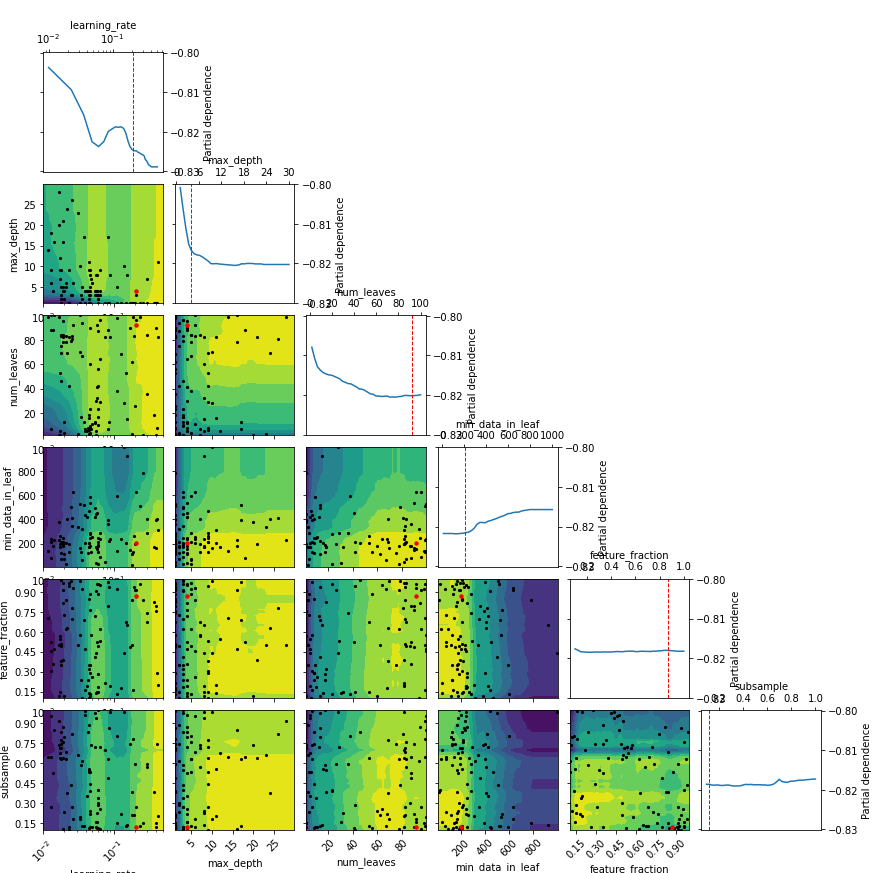

In [12]:
with neptune.create_experiment(name='skopt forest sweep',
                               params=experiment_params,
                               tags=['skopt', 'forest'],):
    results = skopt.forest_minimize(objective, SPACE,
                                    callback=[monitor],
                                    **HPO_PARAMS)
    best_auc = -1.0 * results.fun
    best_params = results.x
    
    # log metrics
    print('Best Validation AUC: {}'.format(best_auc))
    print('Best Params: {}'.format(best_params))
    
    neptune.send_metric('validation auc', best_auc)
    neptune.set_property('best_params', str(to_named_params(best_params)))
    
    # log results
    skopt.dump(results, 'artifacts/forest_results.pkl')
    joblib.dump(SPACE, 'artifacts/forest_space.pkl')

    neptune.send_artifact('artifacts/forest_results.pkl')
    neptune.send_artifact('artifacts/forest_space.pkl')
    
    # log diagnostic plots
    fig, ax = plt.subplots(figsize=(16,12))
    skopt.plots.plot_convergence(results, ax=ax)
    fig.savefig('plots/forest_convergence.png')
    
    neptune.send_image('diagnostics', 'plots/forest_convergence.png')
   
    axes = skopt.plots.plot_evaluations(results)
    fig = axes2fig(axes, figsize=(16,12))
    fig.savefig('plots/forest_evaluations.png')
    
    neptune.send_image('diagnostics', 'plots/forest_evaluations.png')

    axes = skopt.plots.plot_objective(results)
    fig = axes2fig(axes, figsize=(16,12))
    fig.savefig('plots/forest_objective.png')
    
    neptune.send_image('diagnostics', 'plots/forest_objective.png')
